In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
hate_data = pd.read_csv("hate_speech_binary_dataset.csv", delimiter=",") # 혐오 문장
genderbias_data = pd.read_csv('genderbias.csv', sep=',')  # 여성 비하 문장
ilbe_data = pd.read_csv('badword.csv',encoding='CP949') # 일베 문장

## 문장 전처리

In [3]:
# 혐오 문장 처리
hate_data.columns = ['comment', 'label'] # 컬럼 명 변경
hate_data = hate_data.astype({'comment': 'str'})
hate_data = hate_data[hate_data['label']==1]

In [4]:
# 여성 비하 문장 처리
del genderbias_data['bias']    #해당 데이터셋의 필요없는 열 제거
del genderbias_data['hate']    #해당 데이터셋의 필요없는 열 제거
genderbias_data['contain_gender_bias'] = genderbias_data['contain_gender_bias'].replace([False, True],[0,1])  # 구분하기 쉽게 기존의 표기를 0,1로 변경
# genderbias_data = genderbias_data[['contain_gender_bias', 'comments']]    #구분하기 쉽게 열의 순서를 변경

genderbias_data.columns = ['comment', 'label'] # 컬럼 명 변경
genderbias_data = genderbias_data[genderbias_data['label']==1]

In [5]:
# 일베 문장 처리
ilbe_data = ilbe_data[['v2', 'v1']]    #구분하기 쉽게 열의 순서를 변경
ilbe_data.columns = ['comment', 'label'] # 컬럼 명 변경
ilbe_data = ilbe_data[ilbe_data['label']==1]

In [6]:
# 데이터 개수
print("hate_data : %d" % len(hate_data))
print("genderbias_data : %d" % len(genderbias_data))
print("ilbe_data : %d" % len(ilbe_data))

hate_data : 100000
genderbias_data : 1232
ilbe_data : 2044


## 라벨링 및 합치기

In [7]:
# 렌덤하게 문장 추출 후 라벨링 거치는 함수
def random_labeling(data, classified_data, label_num, str_num):  # label_num : 라벨링 시킬 값, str_num 추출할 문장 개수
    random_data = classified_data.sample(n=str_num) # str_num 개의 행(문장) 랜덤 추출
    random_data.loc[random_data.label == 1, 'label'] = label_num # label_num으로 값 변경
    data = data.append(random_data)  # data 에 랜덤 추출된 데이터 추가
    return data

In [8]:
data_declaration = {
    'comment' : ["str_Declaration"],
    'label':[-1]
}


data = pd.DataFrame(data_declaration)
data

,comment,label
0,str_Declaration,-1


In [9]:
# 문장 개수를 모두 2000 개로 지정 각 
# 라벨은 혐오:0, 여성비하: 1, 일베: 2로 지정됨
data = random_labeling(data, hate_data, 0, 2000)
data = random_labeling(data, genderbias_data, 1, 1200)
data = random_labeling(data, ilbe_data, 2, 2000)

In [10]:
# 첫번째 행 제거
data = data.drop(0)

In [11]:
# 랜덤하게 섞기 
data = data.sample(frac=1).reset_index(drop=True)

In [12]:
data[:10]

,comment,label
0,느그애미 수원에서 외노자 보지대주다가,2
1,결제한세끼들도 다 잡아족쳐야지,2
2,한녀들 문재인 대통령님이 G20 정상회담하는 와중에도 이런거나 보고 앉아있지 또? ...,1
3,노벨과 개미인가 시발 엄마가 강제로 뭐 했길래오면 풀고서 내놓으면 채점해준대서 별 ...,2
4,사망교회,2
5,08에 땅값이 떨어져서 지금 떨어졌냐고 병신아 ㅋㅋㅋㅋㅋㅋ 아니 시발 08년도에 지...,2
6,아가리가 왜저렇냐,2
7,좃 때라 쫄보새퀴야,2
8,이 여시 왜 또 슬쩍 관종짓에 끼어드는데 누가 널 지목이라도 했냐,1
9,삼성이 그럼 전라도 사람 존나 뽑은거네? ㅋㅋㅋㅋㅋㅋ말이 되는 개소리를 좀 해라 ㅉ,2


## 중복 및 null 처리

In [13]:
def detect_overlap(data):
    exist_overlap = len(data)  # 데이터 전체 개수
    no_overlap = data['comment'].nunique()  # 중복 제거된 개수
    if exist_overlap != no_overlap:
        data.drop_duplicates(subset=['comment'], inplace=True)

In [14]:
detect_overlap(data)

In [15]:
# null 값 확인
data.isnull().values.any()

False

## 토큰화

In [16]:
def tokenize(x_data, tokenizer):
    tokenizer.fit_on_texts(x_data) # 데이터의 각 행별로 토큰화 수행
    return tokenizer.texts_to_sequences(x_data)    

In [17]:
x_data = data['comment']
y_data = data['label']

In [18]:
tokenizer = Tokenizer()
sequences = tokenize(x_data, tokenizer)

## 희귀단어 확인

In [19]:
def detect_rareword(tokenizer, threshold):
    word_to_index = tokenizer.word_index 
    total_cnt = len(word_to_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

In [20]:
# 희귀 단어 확인
detect_rareword(tokenizer, 2)

등장 빈도가 1번 이하인 희귀 단어의 수: 23571
단어 집합(vocabulary)에서 희귀 단어의 비율: 83.34865629420085
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 48.81842470434729


## 훈련 데이터, 테스트 데이터 분리

In [21]:
# 가장 긴 길이
def max_length(X_data):
    return max(len(l) for l in X_data)

# 훈련 학습 데이터 개수
def num_dataset(raio, X_data):
    num_train = int(len(X_data)*0.8)
    num_test = int(len(X_data) - num_train)
    return num_train, num_test

# 훈련 및 학습 데이터 분리
def config_dataset(num_train, data):
    X_test = data[num_train:] #X_data 데이터 중에서 뒤의 개의 데이터만 저장
    y_test = np.array(y_data[num_train:]) #y_data 데이터 중에서 뒤의 개의 데이터만 저장
    X_train = data[:num_train] #X_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    y_train = np.array(y_data[:num_train]) #y_data 데이터 중에서 앞의 n_of_train개의 데이터만 저장
    
    return X_test, y_test, X_train, y_train

In [22]:
# 최대 길이 계산
X_data = sequences
maxlen = max_length(X_data)

## 문장 길이 분포 확인

문장 최대 길이 : 194
문장 평균 길이 : 9.308463


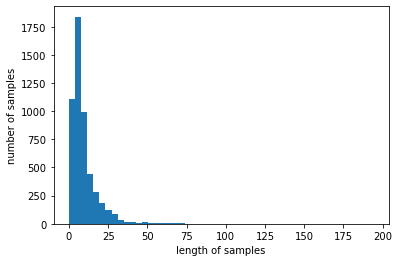

In [23]:
print('문장 최대 길이 : %d' % max(len(l) for l in X_data))
print('문장 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## 훈련 데이터, 학습 데이터 분할

In [24]:
# 훈련 및 학습 데이터 개수 비율 지정
numtrain, numtest = num_dataset(0.8, X_data)

In [25]:
# 가장 긴 길이로 맞추기
data = pad_sequences(X_data, maxlen = maxlen)

In [26]:
X_test, y_test, X_train, y_train = config_dataset(numtrain, data)

# 학습 과정

## 모델 학습

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import pandas as pd
import tensorflow.keras.metrics 

In [28]:
size = 1000000
model = Sequential()
model.add(Embedding(size , 64, input_length = maxlen)) #워드 임베딩
model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
model.add(Conv1D(64, 3, padding='valid', activation='relu')) #hidden layer 추가
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5)) #과적합 방지를 위해 일부 Drop, 기본 50% 정도를 Drop하도록 설정함.
num_of_class = 3 #클래스는 우선 4개로 분류함
model.add(Dense(num_of_class, activation='linear'))
##model.add(Dense(num_of_class, activation='softmax')) #마지막 레이어는 softmax로 출력하게 함
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 194, 64)           64000000  
_________________________________________________________________
dropout (Dropout)            (None, 194, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 192, 64)           12352     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [29]:
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True),metrics= ["accuracy"])
es = EarlyStopping(monitor='loss', mode='min' , min_delta=0)
check_point = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True)

## Training

In [30]:
hist = model.fit(X_train, y_train, batch_size = 16, epochs=10, callbacks=[es, check_point])

Epoch 1/10
260/260 [==============================] - 389s 1s/step - loss: 1.0885 - accuracy: 0.3731
Epoch 2/10
260/260 [==============================] - 435s 2s/step - loss: 1.0576 - accuracy: 0.4428
Epoch 3/10
260/260 [==============================] - 464s 2s/step - loss: 0.7772 - accuracy: 0.6609
Epoch 4/10
260/260 [==============================] - 624s 2s/step - loss: 0.3561 - accuracy: 0.8692
Epoch 5/10
260/260 [==============================] - 439s 2s/step - loss: 0.1247 - accuracy: 0.9660
Epoch 6/10
260/260 [==============================] - 430s 2s/step - loss: 0.0586 - accuracy: 0.9855
Epoch 7/10
260/260 [==============================] - 517s 2s/step - loss: 0.0307 - accuracy: 0.9940
Epoch 8/10
260/260 [==============================] - 431s 2s/step - loss: 0.0194 - accuracy: 0.9953
Epoch 9/10
260/260 [==============================] - 511s 2s/step - loss: 0.0190 - accuracy: 0.9960
Epoch 10/10
260/260 [==============================] - 406s 2s/step - loss: 0.0212 - accura

In [31]:
X_result = model.predict(X_test, batch_size = 16)
X_result

array([[ 3.1673913 , -1.0376067 , -1.5850551 ],
       [-8.461404  , -4.648128  ,  7.7991724 ],
       [ 5.8098283 , -1.9957899 , -3.0081003 ],
       ...,
       [ 3.8704011 , -1.9840438 , -1.338996  ],
       [-0.73853105,  1.2294171 , -0.73430175],
       [-7.037436  , -4.530269  ,  7.0018    ]], dtype=float32)

# OpenMax

In [32]:
class_result = []
for a,b,c in X_result:
    numbers = [a,b,c]
    class_result.append(numbers.index(max(numbers)))
    
tf_result = (y_test == class_result)

for_open_max_0 = []; 
for_open_max_1 = [];
for_open_max_2 = [];

for i in range(len(class_result)):
    if(tf_result[i] == True):
        if(class_result[i] == 0):
            for_open_max_0.append(X_result[i])
        if(class_result[i] == 1):
            for_open_max_1.append(X_result[i])
        if(class_result[i] == 2):
            for_open_max_2.append(X_result[i])

## 평균 Logit Vector 계산

In [33]:
def average_vector(for_open_max, class_result):
    a1=0
    a2=0
    a3=0
    for i in for_open_max:
        a1 += i[0]
        a2 += i[1]
        a3 += i[2]
    length = len(class_result)
    average = [a1/length, a2/length, a3/length]
    return average

average_0 = average_vector(for_open_max_0, class_result) #평균 Logit Vector - Class 0
average_1 = average_vector(for_open_max_1, class_result) #평균 Logit Vector - Class 1
average_2 = average_vector(for_open_max_2, class_result) #평균 Logit Vector - Class 2

## Distance 계산

In [77]:
def distance(for_open_max, average):
    dist = []
    for i in for_open_max:
        m = i - average
        distance = (m[0]**2) + (m[1]**2) + (m[2]**2)
        dist.append(distance)
    return dist

dist0 = distance(for_open_max_0, average_0)
dist1 = distance(for_open_max_1, average_1)
dist2 = distance(for_open_max_2, average_2)

dist0.sort(reverse =True)
dist1.sort(reverse =True)
dist2.sort(reverse =True)

In [79]:
# Distance 상위 20개 추출
maxdist0=[]
maxdist1=[]
maxdist2=[]
for i in range(0,20):
    maxdist0.append(dist0[i])
for j in range(0,20):
    maxdist1.append(dist1[j])
for k in range(0,20):
    maxdist2.append(dist2[k])

In [89]:
#극단 분포 도구
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt

def weib(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)

216.39972678900395 61.89274420032813


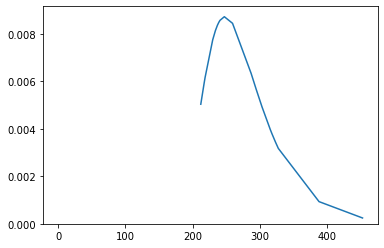

In [90]:
# 0 라벨 Distance 극단 분포 
(loc, scale) = s.exponweib.fit_loc_scale(maxdist0, 1, 1)
print(loc, scale)

plt.plot(maxdist0, s.exponweib.pdf(maxdist0, *s.exponweib.fit(maxdist0, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist0, bins=np.linspace(0, 16, 33), alpha=0.5);
plt.show()

83.02345607156778 45.38959741726491


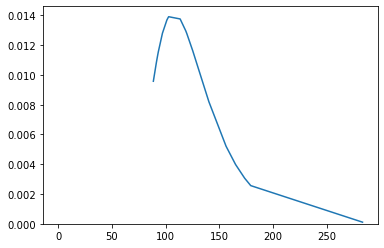

In [91]:
# 1 라벨 Distance 극단 분포 
(loc, scale) = s.exponweib.fit_loc_scale(maxdist1, 1, 1)
print(loc, scale)

plt.plot(maxdist1, s.exponweib.pdf(maxdist1, *s.exponweib.fit(maxdist1, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist1, bins=np.linspace(0, 16, 33), alpha=0.5);
plt.show()

204.12577446651767 90.80200095907512


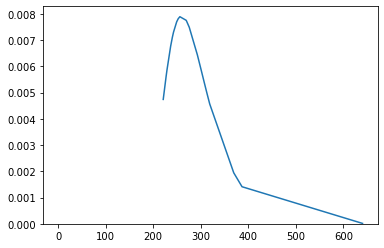

In [92]:
# 2 라벨 Distance 극단 분포 
(loc, scale) = s.exponweib.fit_loc_scale(maxdist2, 1, 1)
print(loc, scale)

plt.plot(maxdist2, s.exponweib.pdf(maxdist2, *s.exponweib.fit(maxdist2, 1, 1, scale=2, loc=0)))
_ = plt.hist(maxdist2, bins=np.linspace(0, 16, 33), alpha=0.5);
plt.show()

## Softmax Layer 통과

In [93]:
model2 = Sequential()
model2.add(Dense(num_of_class + 1, activation = 'softmax'))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics= ["accuracy"])

In [94]:
model2.fit(X_result, y_test, batch_size = 16)

65/65 [==============================] - 2s 3ms/step - loss: 5.2954 - accuracy: 0.1128


In [95]:
model2.predict(X_result, batch_size = 16)

array([[8.6359918e-02, 2.3154963e-02, 2.3716262e-02, 8.6676884e-01],
       [7.1489085e-03, 9.9257976e-01, 2.7081519e-04, 4.7094565e-07],
       [1.5108161e-02, 1.3348236e-03, 1.3109352e-03, 9.8224604e-01],
       ...,
       [5.8428355e-02, 1.7511977e-02, 6.2514986e-03, 9.1780818e-01],
       [1.8589059e-01, 1.0480331e-01, 6.2426680e-01, 8.5039221e-02],
       [1.2038881e-02, 9.8752719e-01, 4.3039292e-04, 3.5025466e-06]],
      dtype=float32)

## 결과 확인

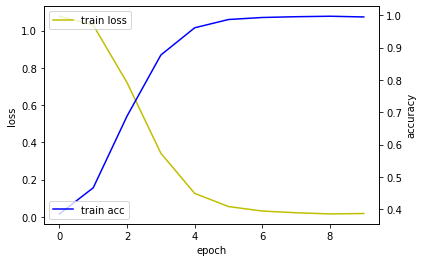

In [96]:
#모델 학습 과정 표시

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [97]:
result = pd.DataFrame(model.predict(X_test, batch_size=16),columns=['0', '1', '2'])
result["Test Label"] = y_test
result["Classification Result"] = class_result
result["Final Result"] = (y_test == class_result)

result.to_csv("test_result.csv")

In [98]:
print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 1s 8ms/step - loss: 0.9112 - accuracy: 0.7389
테스트 정확도: 0.7389


## 모델 저장

In [99]:
##모델을 .json 파일 형식으로 save하여 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
model.save_weights("model_weight.h5")
model.save('full_model.h5')

In [100]:
##모델 조정이 끝나면, Model을 사용 하여 OpenMax에 필요한 자료를 선정하여 OpenMax로 구현할 예정입니다.